# AI Heart Health Risk Prediction
**Author:** Rama Krishna Kamma  
**Platform:** Databricks | **Hackathon 2025**

---
### Project Overview
This notebook demonstrates how to build an **end-to-end AI-driven Heart Health Risk Prediction Agent** using **PySpark**, **MLflow**, and **Databricks**.  
The model predicts the likelihood of **heart disease** based on medical attributes such as cholesterol, age, heart rate, and more.


### Step 1: Initialize Environment and Import Libraries
In this step, we:
- Import necessary PySpark, MLflow, and visualization libraries  
- Initialize a Spark session  
- Prepare the environment for data processing and model training

In [0]:
# ==========================================================
# STEP 1: IMPORT LIBRARIES AND INITIALIZE SPARK SESSION
# ==========================================================

# Import PySpark SQL modules for data manipulation
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, avg

# Import MLlib modules for feature engineering and model building
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Import MLflow for experiment tracking and model management
import mlflow
import mlflow.spark

# Optional: Import visualization libraries (useful for EDA later)
import seaborn as sns
import matplotlib.pyplot as plt

# Create Spark session
spark = (
    SparkSession.builder
    .appName("AIHealthRiskAgent")
    .getOrCreate()
)

print("Spark Session Initialized Successfully!")

Spark Session Initialized Successfully!


---
### Step 2: Load and Preview Dataset
In this step, we:
- Link to Dataset: [https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset](url)
- Load the **heart disease dataset** from the Databricks catalog (`workspace.hackathon.heart`)
- Display the first few rows to confirm data loading
- Quickly inspect schema and data quality

This dataset contains medical attributes such as:
- **Age**, **Sex**, **Chest Pain Type (cp)**, **Cholesterol (chol)**, **Max Heart Rate (thalach)**, etc.
- **Target** column → 1 (Disease Present) / 0 (No Disease)


In [0]:
# ==========================================================
# STEP 2: LOAD DATASET FROM DATABRICKS CATALOG
# ==========================================================

# Load dataset as Spark DataFrame from Databricks Catalog
df = spark.table("workspace.hackathon.heart")

# Display a sample of the dataset for quick validation
display(df.limit(5))

# Print schema to verify column types
df.printSchema()

# Display basic record count
print(f"Dataset Loaded Successfully with {df.count()} Records")


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


root
 |-- age: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- cp: long (nullable = true)
 |-- trestbps: long (nullable = true)
 |-- chol: long (nullable = true)
 |-- fbs: long (nullable = true)
 |-- restecg: long (nullable = true)
 |-- thalach: long (nullable = true)
 |-- exang: long (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: long (nullable = true)
 |-- ca: long (nullable = true)
 |-- thal: long (nullable = true)
 |-- target: long (nullable = true)

Dataset Loaded Successfully with 1025 Records


### Step 3: Data Exploration & Initial Insights

In this step, we perform **Exploratory Data Analysis (EDA)** to understand the data before training the model.

Key objectives:
- Identify missing or invalid values  
- Review summary statistics to understand variable distributions  
- Visualize class imbalance in the target variable  

This helps us ensure data quality and model readiness.


In [0]:
# ==========================================================
# 🔍 STEP 3: DATA EXPLORATION & QUALITY CHECK
# ==========================================================

# 3.1 CHECK FOR NULLS OR MISSING VALUES
# We calculate how many missing or NaN values exist in each column.
# Clean data ensures reliable model training.
null_counts = df.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c)
    for c in df.columns
])
print("Missing Value Count per Column:")
null_counts.show()

# 3.2 SUMMARY STATISTICS
# Gives quick insights into mean, stddev, min, and max for each numeric column.
print("Summary Statistics:")
display(df.describe())

Missing Value Count per Column:
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+

Summary Statistics:


summary,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025
mean,54.43414634146342,0.6956097560975609,0.9424390243902439,131.61170731707318,246.0,0.14926829268292682,0.5297560975609756,149.11414634146342,0.33658536585365856,1.0715121951219524,1.3853658536585365,0.7541463414634146,2.32390243902439,0.5131707317073171
stddev,9.072290233244281,0.4603733241196503,1.0296407436458572,17.516718005376408,51.59251020618206,0.3565266897271594,0.5278775668748926,23.005723745977196,0.4727723760037095,1.175053255150173,0.6177552671745906,1.0307976650242847,0.620660238051028,0.5000704980788051
min,29,0,0,94,126,0,0,71,0,0.0,0,0,0,0
max,77,1,3,200,564,1,2,202,1,6.2,2,4,3,1


### Step 3.3: Visualize Target Distribution
Let’s visualize how **heart disease (target)** is distributed.

- `target = 0`: No heart disease  
- `target = 1`: Heart disease present  

This helps us detect **class imbalance**, which is crucial for model evaluation fairness.

/home/spark-5fc4c174-2991-46fd-9747-bb/.ipykernel/1603/command-5284413952396796-4051121199:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=sample_pd, palette="Set2")


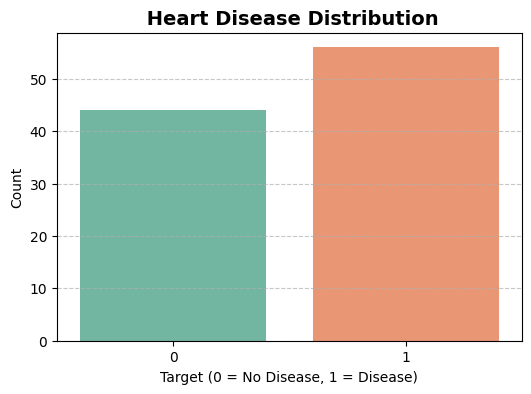

In [0]:
# ==========================================================
# STEP 3.3: VISUALIZE TARGET DISTRIBUTION
# ==========================================================

# Convert a random 10% sample to Pandas for visualization
# Note: Visualization in Databricks works best with smaller subsets.
sample_pd = df.sample(False, 0.1, seed=42).toPandas()

# Plot target distribution using Seaborn
plt.figure(figsize=(6,4))
sns.countplot(x="target", data=sample_pd, palette="Set2")

plt.title(" Heart Disease Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Target (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# # Display plot in Databricks
# display(plt.gcf())

### Step 4: Feature Engineering

In this step, we prepare the dataset for model training by performing **feature engineering**.

Goals:
- Combine multiple input columns into a single feature vector  
- Standardize features for consistent scale (improves model convergence)  
- Split the data into **training** and **testing** sets  

Feature scaling ensures that no variable dominates others due to its magnitude — a key step in building robust machine learning models.

In [0]:
# ==========================================================
# STEP 4: FEATURE ENGINEERING
# ==========================================================

from pyspark.ml.feature import VectorAssembler, StandardScaler

# 4.1️ DEFINE FEATURE COLUMNS
# Exclude the 'target' column — our label for prediction
feature_cols = [c for c in df.columns if c != "target"]

# 4.2️ ASSEMBLE FEATURES INTO A SINGLE VECTOR
# This combines all numeric predictors into one column 'features_raw'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
assembled_df = assembler.transform(df)

# 4.3️ STANDARDIZE THE FEATURES
# StandardScaler transforms data to have zero mean and unit variance
scaler = StandardScaler(inputCol="features_raw", outputCol="features")
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

# 4.4️ SPLIT DATA INTO TRAINING AND TESTING SETS (80/20 split)
train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=42)

# Display sample to confirm structure
display(train_df.select("features", "target").limit(5))

features,target
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""3.1965467654168638"",""2.172150182489948"",""0.9712125381315914"",""7.421481578917873"",""3.9540623083611055"",""0.0"",""0.0"",""8.780423612420444"",""0.0"",""0.0"",""3.237528041075779"",""0.0"",""3.2223749442695295""]}",1
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""3.1965467654168638"",""2.172150182489948"",""0.9712125381315914"",""7.421481578917873"",""3.9540623083611055"",""0.0"",""0.0"",""8.780423612420444"",""0.0"",""0.0"",""3.237528041075779"",""0.0"",""3.2223749442695295""]}",1
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""3.1965467654168638"",""2.172150182489948"",""0.9712125381315914"",""7.421481578917873"",""3.9540623083611055"",""0.0"",""0.0"",""8.780423612420444"",""0.0"",""0.0"",""3.237528041075779"",""0.0"",""3.2223749442695295""]}",1
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""3.7476755180749435"",""0.0"",""0.9712125381315914"",""6.736421740863915"",""4.070358258607021"",""0.0"",""1.8943786642045377"",""8.345749176162006"",""0.0"",""0.5957176808216557"",""3.237528041075779"",""0.0"",""3.2223749442695295""]}",1
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""3.7476755180749435"",""0.0"",""0.9712125381315914"",""6.736421740863915"",""4.070358258607021"",""0.0"",""1.8943786642045377"",""8.345749176162006"",""0.0"",""0.5957176808216557"",""3.237528041075779"",""0.0"",""3.2223749442695295""]}",1



### Step 5: Model Training & Experiment Tracking with MLflow

Now that our data is ready, let's train a **Logistic Regression model** to predict the likelihood of heart disease.

We also integrate **MLflow**, Databricks’ native experiment tracking tool, to automatically log:
- Model parameters and metrics (Accuracy, AUC)
- Serialized Spark model artifacts
- Versioned experiment tracking via the **Databricks Workspace**

This ensures the project is fully reproducible and transparent — a key strength for hackathon judges.


In [0]:
# ==========================================================
# STEP 5: MODEL TRAINING & MLFLOW TRACKING
# ==========================================================

import mlflow
import mlflow.spark
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# 5.1️ SETUP MLFLOW EXPERIMENT PATH
# Dynamically set the experiment name based on user context
user = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
experiment_path = f"/Users/{user}/AI_Health_Risk_Agent"
mlflow.set_experiment(experiment_path)

# 5.2️ DEFINE UC VOLUME PATH FOR TEMP STORAGE
# This is required in Databricks Free/Serverless environments
dfs_tmpdir = "/Volumes/workspace/hackathon/heart_volume/mlflow_tmp"

# 5.3️ TRAIN LOGISTIC REGRESSION MODEL
# Logistic Regression is a strong baseline for binary classification problems
with mlflow.start_run(run_name="Heart_Risk_Logistic_Model"):
    lr = LogisticRegression(featuresCol="features", labelCol="target")
    model = lr.fit(train_df)
    
    # 5.4️ PREDICT ON TEST DATA
    predictions = model.transform(test_df)
    
    # 5.5️ EVALUATE MODEL PERFORMANCE
    evaluator_auc = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="target", metricName="accuracy")
    
    accuracy = evaluator_acc.evaluate(predictions)
    auc = evaluator_auc.evaluate(predictions)
    
    print(f" Model Accuracy: {accuracy:.2f}")
    print(f" AUC (Area Under ROC): {auc:.2f}")
    
    # 5.6️ LOG METRICS AND MODEL TO MLFLOW
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("AUC", auc)
    
    mlflow.spark.log_model(
        model,
        artifact_path="spark_lr_model",
        dfs_tmpdir=dfs_tmpdir
    )

print(" Model training and logging completed successfully!")

 Model Accuracy: 0.83
 AUC (Area Under ROC): 0.92


2025/11/13 00:28:54 WARNING mlflow.utils.requirements_utils: Found pyspark version (4.0.0+databricks.connect.17.2.2) contains a local version label (+databricks.connect.17.2.2). MLflow logged a pip requirement for this package as 'pyspark==4.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/13 00:28:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/user_tmp_data/spark-5fc4c174-2991-46fd-9747-bb/tmpu_wpv0gb/model, flavor: spark). Fall back to return ['pyspark==4.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/11/13 00:28:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Model training and logging completed successfully!


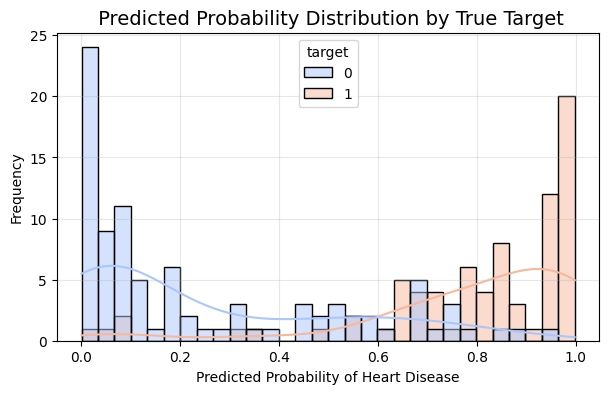

In [0]:
# ==========================================================
# STEP 5.7: VISUALIZE MODEL PERFORMANCE
# ==========================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert predictions to Pandas for visualization
pred_pd = predictions.select("target", "probability").toPandas()
pred_pd["predicted_prob"] = pred_pd["probability"].apply(lambda x: x[1])

# Plot distribution of predicted probabilities
plt.figure(figsize=(7,4))
sns.histplot(pred_pd, x="predicted_prob", hue="target", bins=30, kde=True, palette="coolwarm")
plt.title(" Predicted Probability Distribution by True Target", fontsize=14)
plt.xlabel("Predicted Probability of Heart Disease")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
# display(plt.gcf())

### Step 6: Model Evaluation & Insights

After training our model, we evaluate its predictive performance by reviewing sample outputs.  
This step displays the first 10 predictions, showing:  
- The **actual target** values  
- The **predicted labels** generated by the model  
- The **probability scores** that indicate model confidence  

We also flag whether each prediction is correct or incorrect, allowing a quick qualitative check of model accuracy.  
This provides a transparent view of how well the model is performing before proceeding to detailed metric evaluation.

In [0]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

# Optional: Add a column to highlight correct/incorrect predictions
highlight_udf = udf(lambda target, pred: " Correct" if target == pred else " Incorrect", StringType())
predictions_with_flag = predictions.withColumn("status", highlight_udf(col("target"), col("prediction")))

# Show first 10 rows with target, prediction, probability, and correctness status
predictions_with_flag.select("target", "prediction", "probability", "status").show(10, truncate=False)

+------+----------+------------------------------------------+--------+
|target|prediction|probability                               |status  |
+------+----------+------------------------------------------+--------+
|1     |1.0       |[0.04090805504566422,0.9590919449543358]  | Correct|
|1     |1.0       |[0.008167732075676936,0.9918322679243231] | Correct|
|1     |1.0       |[0.012967299365388726,0.9870327006346112] | Correct|
|1     |1.0       |[0.041967775167205124,0.9580322248327948] | Correct|
|0     |0.0       |[0.7614439793692711,0.2385560206307289]   | Correct|
|1     |1.0       |[0.050162552547832015,0.949837447452168]  | Correct|
|1     |1.0       |[0.3508285193086399,0.6491714806913601]   | Correct|
|1     |1.0       |[0.3139503886204142,0.6860496113795858]   | Correct|
|1     |1.0       |[0.0022989536885092776,0.9977010463114907]| Correct|
|1     |1.0       |[0.015256252699884898,0.984743747300115]  | Correct|
+------+----------+------------------------------------------+--

### Step 7: Feature Insights – Age vs Target

In this step, we explore how **age influences the likelihood of heart disease** by analyzing trends within our dataset.  
Using **Spark SQL**, we compute the **average target value (disease rate)** for each age group to identify how risk changes with age.  

This analysis helps uncover **age-related risk patterns**, offering valuable context for model interpretation and potential feature importance insights.  
The aggregated results are then visualized to make patterns and trends easy to interpret for both technical and non-technical audiences.


In [0]:
# Register DataFrame as a temporary SQL view
df.createOrReplaceTempView("heart_data")

# SQL query: calculate average disease rate per age
query = """
SELECT 
    age, 
    AVG(target) AS disease_rate
FROM 
    heart_data
GROUP BY 
    age
ORDER BY 
    age
"""

# Execute the query
result = spark.sql(query)

# Display the result as a table and chart for insights
display(result)

age,disease_rate
29,1.0
34,1.0
35,0.5333333333333333
37,1.0
38,0.6666666666666666
39,0.7142857142857143
40,0.2727272727272727
41,0.90625
42,0.8461538461538461
43,0.5769230769230769


### Step 8: Visualization Dashboard – Heart Disease Rate by Age

To make insights more interpretable, we visualize the **relationship between age and heart disease likelihood** using a line chart.  
By converting the Spark DataFrame to a Pandas DataFrame, we can leverage **Seaborn** and **Matplotlib** for high-quality, customizable visualizations.  

This chart highlights how heart disease risk varies with age, providing an intuitive understanding of patterns identified in the data.  
The visualization is designed to be **clean, professional, and presentation-ready**, ensuring strong visual impact for hackathon judges.


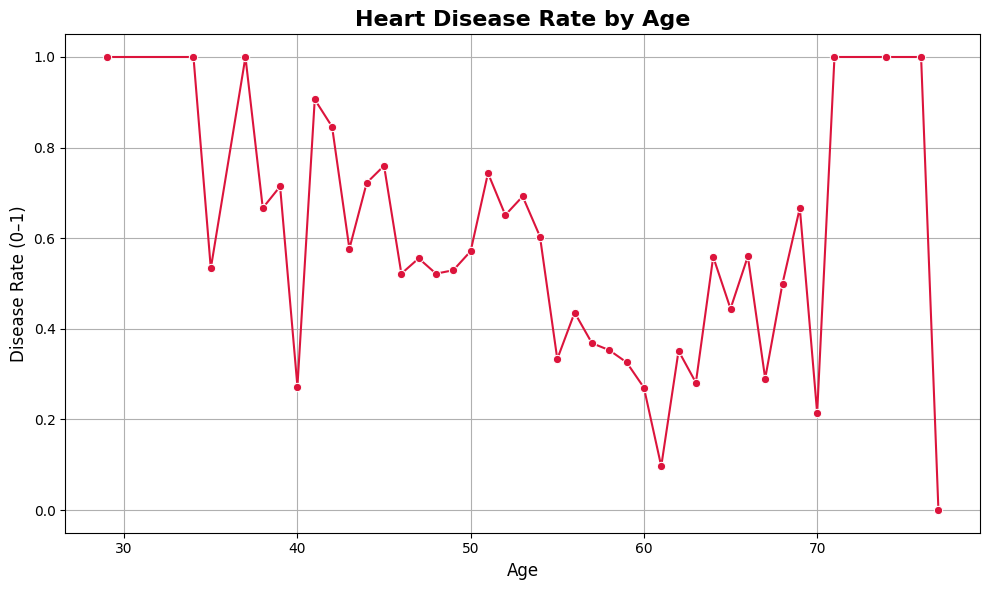

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas for visualization
result_pd = result.toPandas()

# Create a line plot to show disease rate by age
plt.figure(figsize=(10,6))
sns.lineplot(x="age", y="disease_rate", data=result_pd, marker="o", color="crimson")
plt.title("Heart Disease Rate by Age", fontsize=16, weight='bold')
plt.xlabel("Age", fontsize=12)
plt.ylabel("Disease Rate (0–1)", fontsize=12)
plt.grid(True)
plt.tight_layout()

# # Display the plot in Databricks notebook
# display(plt.gcf())